In [1]:
!pip install pmdarima


  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)


Original Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  1.319  1.099  1.035  1.001  0.991  0.992  0.993   1.020      NaN   
2011  1.368  1.110  1.033  1.004  0.995  0.987  0.998   1.047     1.01   
2012  1.477  1.113  1.035  0.996  0.993  1.003  1.003   0.993     1.01   
2013  1.345  1.145  1.028  0.996  0.995  0.998  0.990   1.006     1.02   
2014  1.507  1.149  1.034  1.009  1.002  0.996  0.990   0.994     0.99   

      120→132  132→144  144→156  156→Ult  
2010      NaN      NaN      NaN      NaN  
2011      NaN      NaN      NaN      NaN  
2012    0.981      NaN      NaN      NaN  
2013    1.025    1.019      NaN      NaN  
2014    0.994    0.992     0.99      NaN  

Detected Outliers:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN    NaN    NaN    NaN  0.991    NaN    NaN     NaN      NaN   
2011    NaN    NaN    NaN    NaN    NaN  0.987    NaN   1.047      NaN   
2013    NaN    NaN  1.028    NaN    

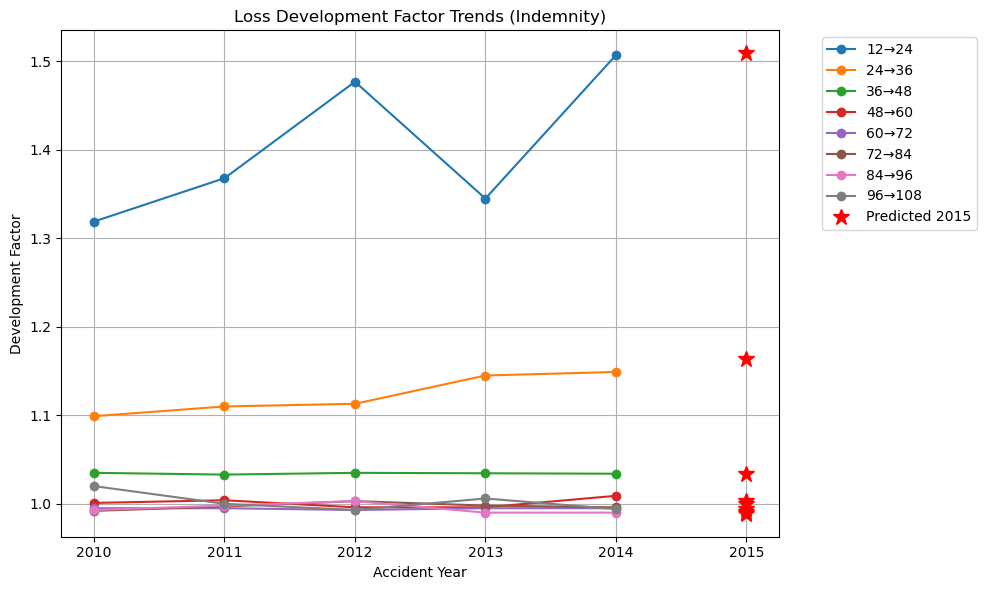

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the triangle data
# ------------------------------
data = {
    2010: [1.319, 1.099, 1.035, 1.001, 0.991, 0.992, 0.993, 1.020, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [1.368, 1.110, 1.033, 1.004, 0.995, 0.987, 0.998, 1.047, 1.010, np.nan, np.nan, np.nan, np.nan],
    2012: [1.477, 1.113, 1.035, 0.996, 0.993, 1.003, 1.003, 0.993, 1.010, 0.981, np.nan, np.nan, np.nan],
    2013: [1.345, 1.145, 1.028, 0.996, 0.995, 0.998, 0.990, 1.006, 1.020, 1.025, 1.019, np.nan, np.nan],
    2014: [1.507, 1.149, 1.034, 1.009, 1.002, 0.996, 0.990, 0.994, 0.990, 0.994, 0.992, 0.990, np.nan]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df = pd.DataFrame(data).T
df.columns = cols

print("Original Triangle:")
print(df)
print()

# ------------------------------
# 2. Detect Outliers (IQR Method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7 * IQR, Q3 + 1 * IQR
    return (series < lower) | (series > upper)

outlier_mask = df.apply(find_outliers)
outliers = df[outlier_mask]

print("Detected Outliers:")
print(outliers.dropna(how="all"))
print()

# ------------------------------
# 3. Replace Outliers with NaN, then fill with Median
# ------------------------------
clean_df = df.mask(outlier_mask)
clean_df = clean_df.apply(lambda col: col.fillna(col.median()), axis=0)

print("Cleaned Triangle (Outliers replaced with median):")
print(clean_df)
print()

# ------------------------------
# 4. Predict next (future) year's ratios using Linear Regression
# ------------------------------
years = np.array(clean_df.index).reshape(-1, 1)       # shape (n_samples, 1)
future_year = np.array([clean_df.index.max() + 1])    # 1D array, will reshape for prediction

predicted_ratios = []
for col in clean_df.columns:
    y = clean_df[col].values
    mask = ~np.isnan(y)
    
    # Only fit if at least 2 data points exist
    if mask.sum() < 2:
        predicted_ratios.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1, 1))[0]  # reshape to (1,1)
    predicted_ratios.append(pred)

predicted_row = pd.Series(predicted_ratios, index=clean_df.columns, name=future_year.item())
print("Predicted Development Factors for Next Year:")
print(predicted_row.round(3))
print()

# ------------------------------
# 5. Visualize the trends and prediction
# ------------------------------
plt.figure(figsize=(10, 6))

# Only plot columns with enough data
for col in clean_df.columns[:8]:  # adjust range if needed
    plt.plot(clean_df.index, clean_df[col], marker='o', label=col)

# Plot predictions for the next year
plt.plot([future_year[0]]*8, predicted_ratios[:8], 'r*', markersize=12, label=f'Predicted {future_year[0]}')


plt.title("Loss Development Factor Trends (Indemnity)")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Original Paid Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  2.657  1.508  1.212  1.115  1.060  1.030  1.015   1.025      NaN   
2011  2.735  1.550  1.236  1.137  1.066  1.032  1.022   1.037    1.023   
2012  3.266  1.546  1.230  1.118  1.057  1.040  1.025   1.003    1.014   
2013  2.885  1.554  1.236  1.117  1.061  1.030  1.017   1.024    1.026   
2014  2.869  1.534  1.236  1.115  1.060  1.027  1.015   1.012    1.011   

      120→132  132→144  144→156  156→Ult  
2010      NaN      NaN      NaN      NaN  
2011      NaN      NaN      NaN      NaN  
2012    1.000      NaN      NaN      NaN  
2013    1.035    1.021      NaN      NaN  
2014    1.012    1.019    1.007      NaN  

Detected Outliers in Paid Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN  1.508  1.212    NaN    NaN    NaN    NaN     NaN      NaN   
2011    NaN    NaN    NaN  1.137  1.066    NaN    NaN   1.037      NaN   
2012  3.266   

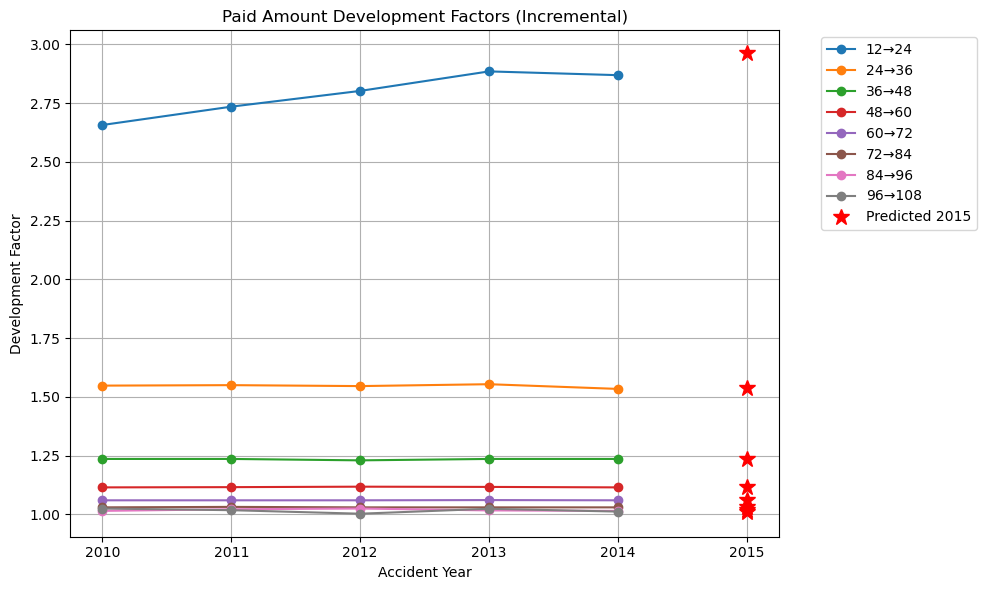

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Paid amount triangle data
# ------------------------------
data_paid = {
    2010: [2.657, 1.508, 1.212, 1.115, 1.060, 1.030, 1.015, 1.025, np.nan, np.nan, np.nan, np.nan, np.nan],
    2011: [2.735, 1.550, 1.236, 1.137, 1.066, 1.032, 1.022, 1.037, 1.023, np.nan, np.nan, np.nan, np.nan],
    2012: [3.266, 1.546, 1.230, 1.118, 1.057, 1.040, 1.025, 1.003, 1.014, 1.000, np.nan, np.nan, np.nan],
    2013: [2.885, 1.554, 1.236, 1.117, 1.061, 1.030, 1.017, 1.024, 1.026, 1.035, 1.021, np.nan, np.nan],
    2014: [2.869, 1.534, 1.236, 1.115, 1.060, 1.027, 1.015, 1.012, 1.011, 1.012, 1.019, 1.007, np.nan]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df_paid = pd.DataFrame(data_paid).T
df_paid.columns = cols

print("Original Paid Triangle:")
print(df_paid)
print()

# ------------------------------
# 2. Detect outliers (IQR method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7*IQR, Q3 + 0.7*IQR
    return (series < lower) | (series > upper)

outlier_mask = df_paid.apply(find_outliers)
outliers = df_paid[outlier_mask]

print("Detected Outliers in Paid Triangle:")
print(outliers.dropna(how='all'))
print()

# ------------------------------
# 3. Replace outliers with NaN, then fill with median
# ------------------------------
clean_paid = df_paid.mask(outlier_mask)
clean_paid = clean_paid.apply(lambda col: col.fillna(col.median()), axis=0)

print("Cleaned Paid Triangle (Outliers replaced with median):")
print(clean_paid)
print()

# ------------------------------
# 4. Predict next year's incremental factors using linear regression
# ------------------------------
years = np.array(clean_paid.index).reshape(-1,1)
future_year = np.array([clean_paid.index.max() + 1])

predicted_inc = []
for col in clean_paid.columns:
    y = clean_paid[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_inc.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1,1))[0]
    predicted_inc.append(pred)

predicted_inc_row = pd.Series(predicted_inc, index=clean_paid.columns, name=future_year.item())
print("Predicted Incremental Factors for Next Year:")
print(predicted_inc_row.round(3))
print()

# ------------------------------
# 5. Compute cumulative table for predicted year
# ------------------------------
cumulative = pd.Series(np.ones(len(cols)), index=cols)  # bottom row = 1 (ultimate)

# Compute cumulative backwards using .iloc to avoid warnings
for i in reversed(range(len(cols)-1)):
    cumulative.iloc[i] = cumulative.iloc[i+1] * predicted_inc_row.iloc[i]

print(f"Cumulative Factors for {future_year[0]}:")
print(cumulative.round(3))
print()

# ------------------------------
# 6. Visualize incremental trends and predictions
# ------------------------------
plt.figure(figsize=(10,6))

num_cols_to_plot = min(8, clean_paid.shape[1])  # adjust number of columns if needed
for col in clean_paid.columns[:num_cols_to_plot]:
    plt.plot(clean_paid.index, clean_paid[col], marker='o', label=col)

plt.plot([future_year[0]]*num_cols_to_plot, predicted_inc[:num_cols_to_plot], 'r*',
         markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Paid Amount Development Factors (Incremental)")
plt.xlabel("Accident Year")
plt.ylabel("Development Factor")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Original Paid Cumulative Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010  7.361  2.558  1.657  1.340  1.201  1.133  1.101   1.084    1.071   
2011  7.705  2.563  1.659  1.344  1.204  1.136  1.101   1.080    1.062   
2012  7.567  2.575  1.665  1.349  1.203  1.133  1.098   1.077    1.063   
2013  7.392  2.564  1.667  1.355  1.210  1.140  1.105   1.085    1.063   
2014  7.392  2.564  1.667  1.355  1.210  1.140  1.105   1.085    1.063   

      120→132  132→144  144→156  156→Ult  
2010    1.052    1.028    1.007      1.0  
2011    1.044    1.028    1.007      1.0  
2012    1.044    1.028    1.007      1.0  
2013    1.044    1.028    1.007      1.0  
2014    1.044    1.028    1.007      1.0  

Detected Outliers in Paid Cumulative Triangle:
      12→24  24→36  36→48  48→60  60→72  72→84  84→96  96→108  108→120  \
2010    NaN  2.558    NaN    NaN    NaN    NaN    NaN     NaN    1.071   
2011  7.705    NaN    NaN    NaN    NaN    NaN    NaN     NaN    1

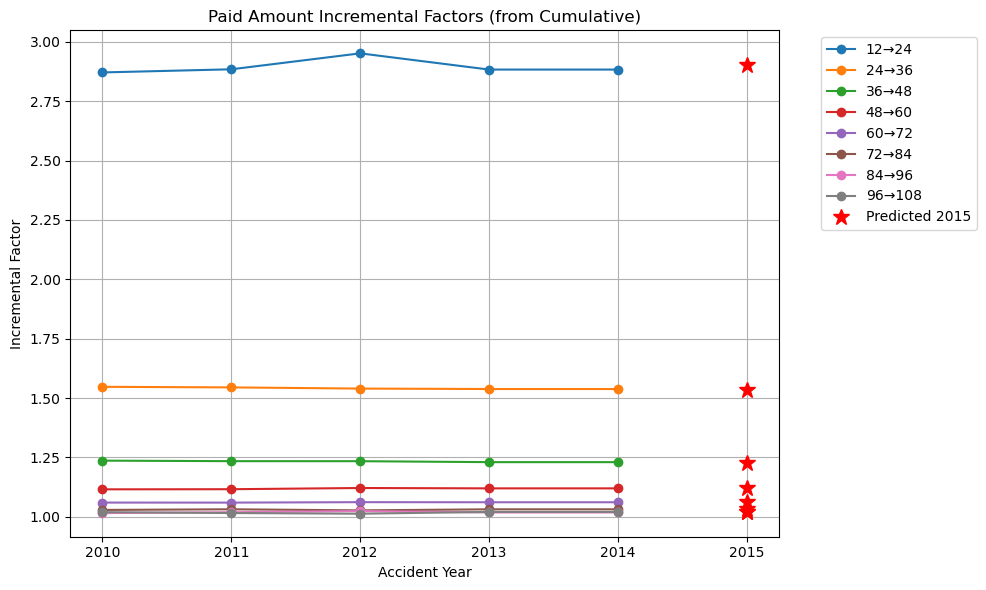

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ------------------------------
# 1. Paid cumulative triangle data
# ------------------------------
data_paid_cum = {
    2010: [7.361, 2.558, 1.657, 1.340, 1.201, 1.133, 1.101, 1.084, 1.071, 1.052, 1.028, 1.007, 1.000],
    2011: [7.705, 2.563, 1.659, 1.344, 1.204, 1.136, 1.101, 1.080, 1.062, 1.044, 1.028, 1.007, 1.000],
    2012: [7.567, 2.575, 1.665, 1.349, 1.203, 1.133, 1.098, 1.077, 1.063, 1.044, 1.028, 1.007, 1.000],
    2013: [7.392, 2.564, 1.667, 1.355, 1.210, 1.140, 1.105, 1.085, 1.063, 1.044, 1.028, 1.007, 1.000],
    2014: [7.392, 2.564, 1.667, 1.355, 1.210, 1.140, 1.105, 1.085, 1.063, 1.044, 1.028, 1.007, 1.000]
}

cols = ["12→24", "24→36", "36→48", "48→60", "60→72", "72→84", "84→96",
        "96→108", "108→120", "120→132", "132→144", "144→156", "156→Ult"]

df_paid_cum = pd.DataFrame(data_paid_cum).T
df_paid_cum.columns = cols

print("Original Paid Cumulative Triangle:")
print(df_paid_cum)
print()

# ------------------------------
# 2. Detect outliers (IQR method)
# ------------------------------
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 0.7*IQR, Q3 + 0.7*IQR
    return (series < lower) | (series > upper)

outlier_mask = df_paid_cum.apply(find_outliers)
outliers = df_paid_cum[outlier_mask]

print("Detected Outliers in Paid Cumulative Triangle:")
print(outliers.dropna(how='all'))
print()

# ------------------------------
# 3. Replace outliers with NaN, then fill with median
# ------------------------------
clean_paid_cum = df_paid_cum.mask(outlier_mask)
clean_paid_cum = clean_paid_cum.apply(lambda col: col.fillna(col.median()), axis=0)

print("Cleaned Paid Cumulative Triangle (Outliers replaced with median):")
print(clean_paid_cum)
print()

# ------------------------------
# 4. Compute incremental factors from cumulative
# ------------------------------
# Incremental factor = current column / next column (backward)
incremental_factors = clean_paid_cum.copy()
for i in range(len(cols)-1):
    incremental_factors.iloc[:, i] = clean_paid_cum.iloc[:, i] / clean_paid_cum.iloc[:, i+1]
incremental_factors.iloc[:, -1] = 1.0  # last column = 1 (ultimate)

print("Calculated Incremental Factors:")
print(incremental_factors)
print()

# ------------------------------
# 5. Predict next year's incremental factors using linear regression
# ------------------------------
years = np.array(incremental_factors.index).reshape(-1,1)
future_year = np.array([incremental_factors.index.max() + 1])

predicted_inc = []
for col in incremental_factors.columns:
    y = incremental_factors[col].values
    mask = ~np.isnan(y)
    
    if mask.sum() < 2:
        predicted_inc.append(np.nan)
        continue
    
    model = LinearRegression()
    model.fit(years[mask], y[mask])
    pred = model.predict(future_year.reshape(-1,1))[0]
    predicted_inc.append(pred)

predicted_inc_row = pd.Series(predicted_inc, index=incremental_factors.columns, name=future_year.item())
print("Predicted Incremental Factors for Next Year:")
print(predicted_inc_row.round(3))
print()

# ------------------------------
# 6. Compute cumulative factors for predicted year
# ------------------------------
cumulative = pd.Series(np.ones(len(cols)), index=cols)  # last column = 1

# Compute cumulative backwards using .iloc
for i in reversed(range(len(cols)-1)):
    cumulative.iloc[i] = cumulative.iloc[i+1] * predicted_inc_row.iloc[i]

print(f"Cumulative Factors for {future_year[0]}:")
print(cumulative.round(3))
print()

# ------------------------------
# 7. Visualize incremental trends and predictions
# ------------------------------
plt.figure(figsize=(10,6))

num_cols_to_plot = min(8, incremental_factors.shape[1])  # plot first 8 columns
for col in incremental_factors.columns[:num_cols_to_plot]:
    plt.plot(incremental_factors.index, incremental_factors[col], marker='o', label=col)

plt.plot([future_year[0]]*num_cols_to_plot, predicted_inc[:num_cols_to_plot], 'r*',
         markersize=12, label=f'Predicted {future_year[0]}')

plt.title("Paid Amount Incremental Factors (from Cumulative)")
plt.xlabel("Accident Year")
plt.ylabel("Incremental Factor")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import re
import warnings

# ---- Suppress warnings ----
warnings.filterwarnings("ignore")

# ---- Step 0: Ensure index is a column named 'AccidentYear' ----
df_long = df.reset_index()
if df_long.columns[0] != 'AccidentYear':
    df_long = df_long.rename(columns={df_long.columns[0]: 'AccidentYear'})

# ---- Step 1: Melt to long format ----
df_long = df_long.melt(
    id_vars='AccidentYear',
    var_name='Dev',
    value_name='Incurred'
)

# ---- Step 1b: Extract numeric starting development period ----
# e.g., '12→24' -> 12
df_long['Dev'] = df_long['Dev'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))

forecast_rows = []

# ---- Step 2: Fit ARIMA per Accident Year ----
for ay in df_long['AccidentYear'].unique():
    ts = df_long[df_long['AccidentYear'] == ay].sort_values('Dev')
    incurred_series = ts['Incurred'].values

    # ---- Pick robust ARIMA based on series length ----
    try:
        if len(incurred_series) <= 5:
            model = ARIMA(incurred_series, order=(0,1,1)).fit()
        else:
            model = ARIMA(incurred_series, order=(1,1,1)).fit()
    except:
        model = ARIMA(incurred_series, order=(0,1,0)).fit()

    # ---- Forecast next 3 development periods ----
    n_forecast = 3
    forecast_vals = model.forecast(steps=n_forecast)

    last_dev = ts['Dev'].max()
    # Use median difference as increment
    dev_increment = int(np.median(np.diff(ts['Dev'])))
    future_devs = [last_dev + dev_increment*i for i in range(1, n_forecast + 1)]

    for dev, val in zip(future_devs, forecast_vals):
        forecast_rows.append({
            'AccidentYear': ay,
            'Dev': dev,
            'Incurred': val
        })

# ---- Step 3: Combine actual + forecast ----
df_forecast = pd.concat(
    [df_long, pd.DataFrame(forecast_rows)],
    ignore_index=True
)

# ---- Step 4: Rebuild triangle ----
df_triangle_forecast = df_forecast.pivot(
    index='AccidentYear',
    columns='Dev',
    values='Incurred'
).sort_index()

df_triangle_forecast



Dev,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192
AccidentYear,,,,,,,,,,,,,,,,
2010,1.319,1.099,1.035,1.001,0.991,0.992,0.993,1.020,NaN,NaN,NaN,NaN,NaN,1.135317,1.142855,1.148766
2011,1.368,1.110,1.033,1.004,0.995,0.987,0.998,1.047,1.01,NaN,NaN,NaN,NaN,0.911437,0.892133,0.872964
2012,1.477,1.113,1.035,0.996,0.993,1.003,1.003,0.993,1.01,0.981,NaN,NaN,NaN,0.884761,0.873451,0.864923
2013,1.345,1.145,1.028,0.996,0.995,0.998,0.990,1.006,1.02,1.025,1.019,NaN,NaN,0.971443,0.958522,0.946837
2014,1.507,1.149,1.034,1.009,1.002,0.996,0.990,0.994,0.99,0.994,0.992,0.99,NaN,1.003962,1.009892,1.015216


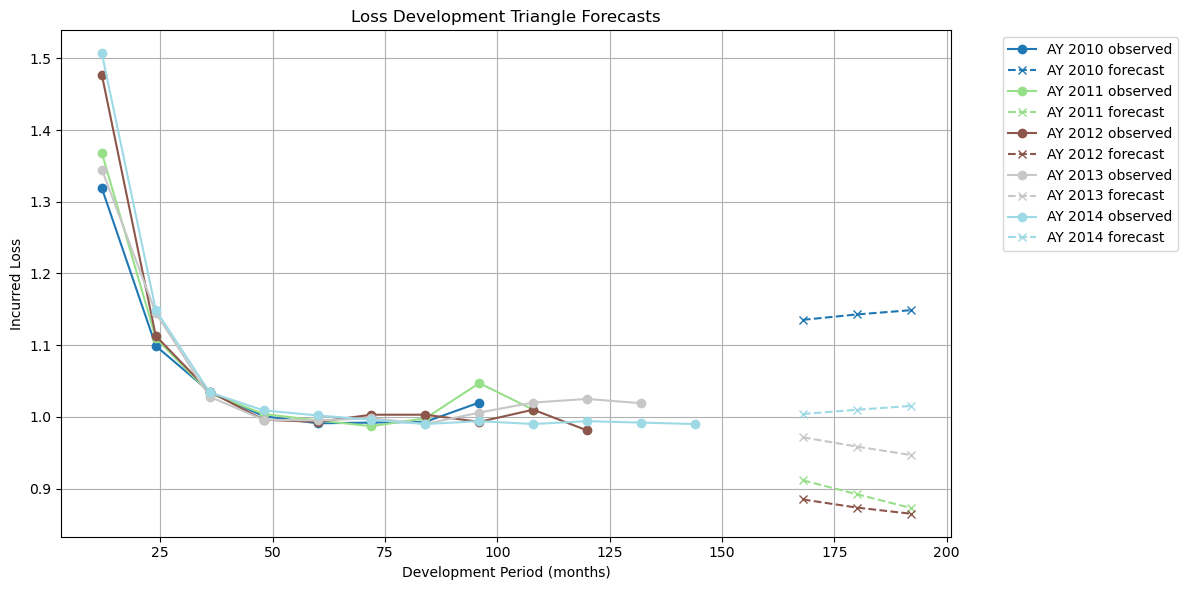

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12, 6))

# Generate a colormap with enough distinct colors
n_years = len(df_triangle_forecast.index)
colors = cm.tab20(np.linspace(0, 1, n_years))  # tab20 has 20 distinct colors

for i, ay in enumerate(df_triangle_forecast.index):
    row = df_triangle_forecast.loc[ay].sort_index()
    
    # Split observed vs forecasted
    observed = row[:len(df.loc[ay])]
    forecasted = row[len(df.loc[ay]):]
    
    color = colors[i]  # same color for this accident year
    
    # Plot observed
    plt.plot(observed.index, observed.values, marker='o', color=color, label=f'AY {ay} observed')
    
    # Plot forecasted
    if len(forecasted) > 0:
        plt.plot(forecasted.index, forecasted.values, marker='x', linestyle='--', color=color, label=f'AY {ay} forecast')

plt.xlabel('Development Period (months)')
plt.ylabel('Incurred Loss')
plt.title('Loss Development Triangle Forecasts')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
"""
AR (AutoRegressive) → current value depends on past values.

MA (Moving Average) → current value depends on past shocks/errors.

Differencing (I) → removes trends or makes series stationary.

3. Why ARIMA works better for loss development triangles

Captures temporal dependence:

Each development period depends on previous periods.

For example, losses at 36 months are highly correlated with losses at 24 months.

Models non-linear accumulation:

Many triangles have fast early development + slow tail development.

ARIMA can capture this “curve” naturally, whereas linear regression cannot.

Handles short-term forecasting:

ARIMA can forecast a few periods ahead using the learned pattern, not just a linear trend.

Accounts for random shocks:

The MA component models unexpected changes, which regression ignores.
"""

'\nAR (AutoRegressive) → current value depends on past values.\n\nMA (Moving Average) → current value depends on past shocks/errors.\n\nDifferencing (I) → removes trends or makes series stationary.\n\n3. Why ARIMA works better for loss development triangles\n\nCaptures temporal dependence:\n\nEach development period depends on previous periods.\n\nFor example, losses at 36 months are highly correlated with losses at 24 months.\n\nModels non-linear accumulation:\n\nMany triangles have fast early development + slow tail development.\n\nARIMA can capture this “curve” naturally, whereas linear regression cannot.\n\nHandles short-term forecasting:\n\nARIMA can forecast a few periods ahead using the learned pattern, not just a linear trend.\n\nAccounts for random shocks:\n\nThe MA component models unexpected changes, which regression ignores.\n'